In [1]:
!pwd

!ls

!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!ls /usr/lib/jvm/

!wget -q https://downloads.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

!tar -xvzf spark-3.4.0-bin-hadoop3.tgz

#install findspark
!pip install -q findspark

#install pyspark
!pip install pyspark

/content
drive  sample_data
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [981 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,251 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,173 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [864 kB]
Hit

In [2]:
import findspark
findspark.init()

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3.tgz"

from pyspark.sql.functions import col, sum as spark_sum

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .config("spark.sql.execution.arrow.enabled", "true") \
        .getOrCreate()

In [3]:

spark_data = spark.read.format('csv').options(header='true', inferSchema = 'true').load("/content/drive/MyDrive/One&only1.csv")

spark_data.show(5,truncate=False)

spark_data.printSchema()

spark_data.count()

spark_data.describe()

null_sum = spark_data.agg(*[spark_sum(col(c).isNull().cast("int")).alias(c) for c in spark_data.columns])

+--------------------+--------+-------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                  |Category|name                     |reviews_rating|reviews_text                                                                                                                                                                                                                                     

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns



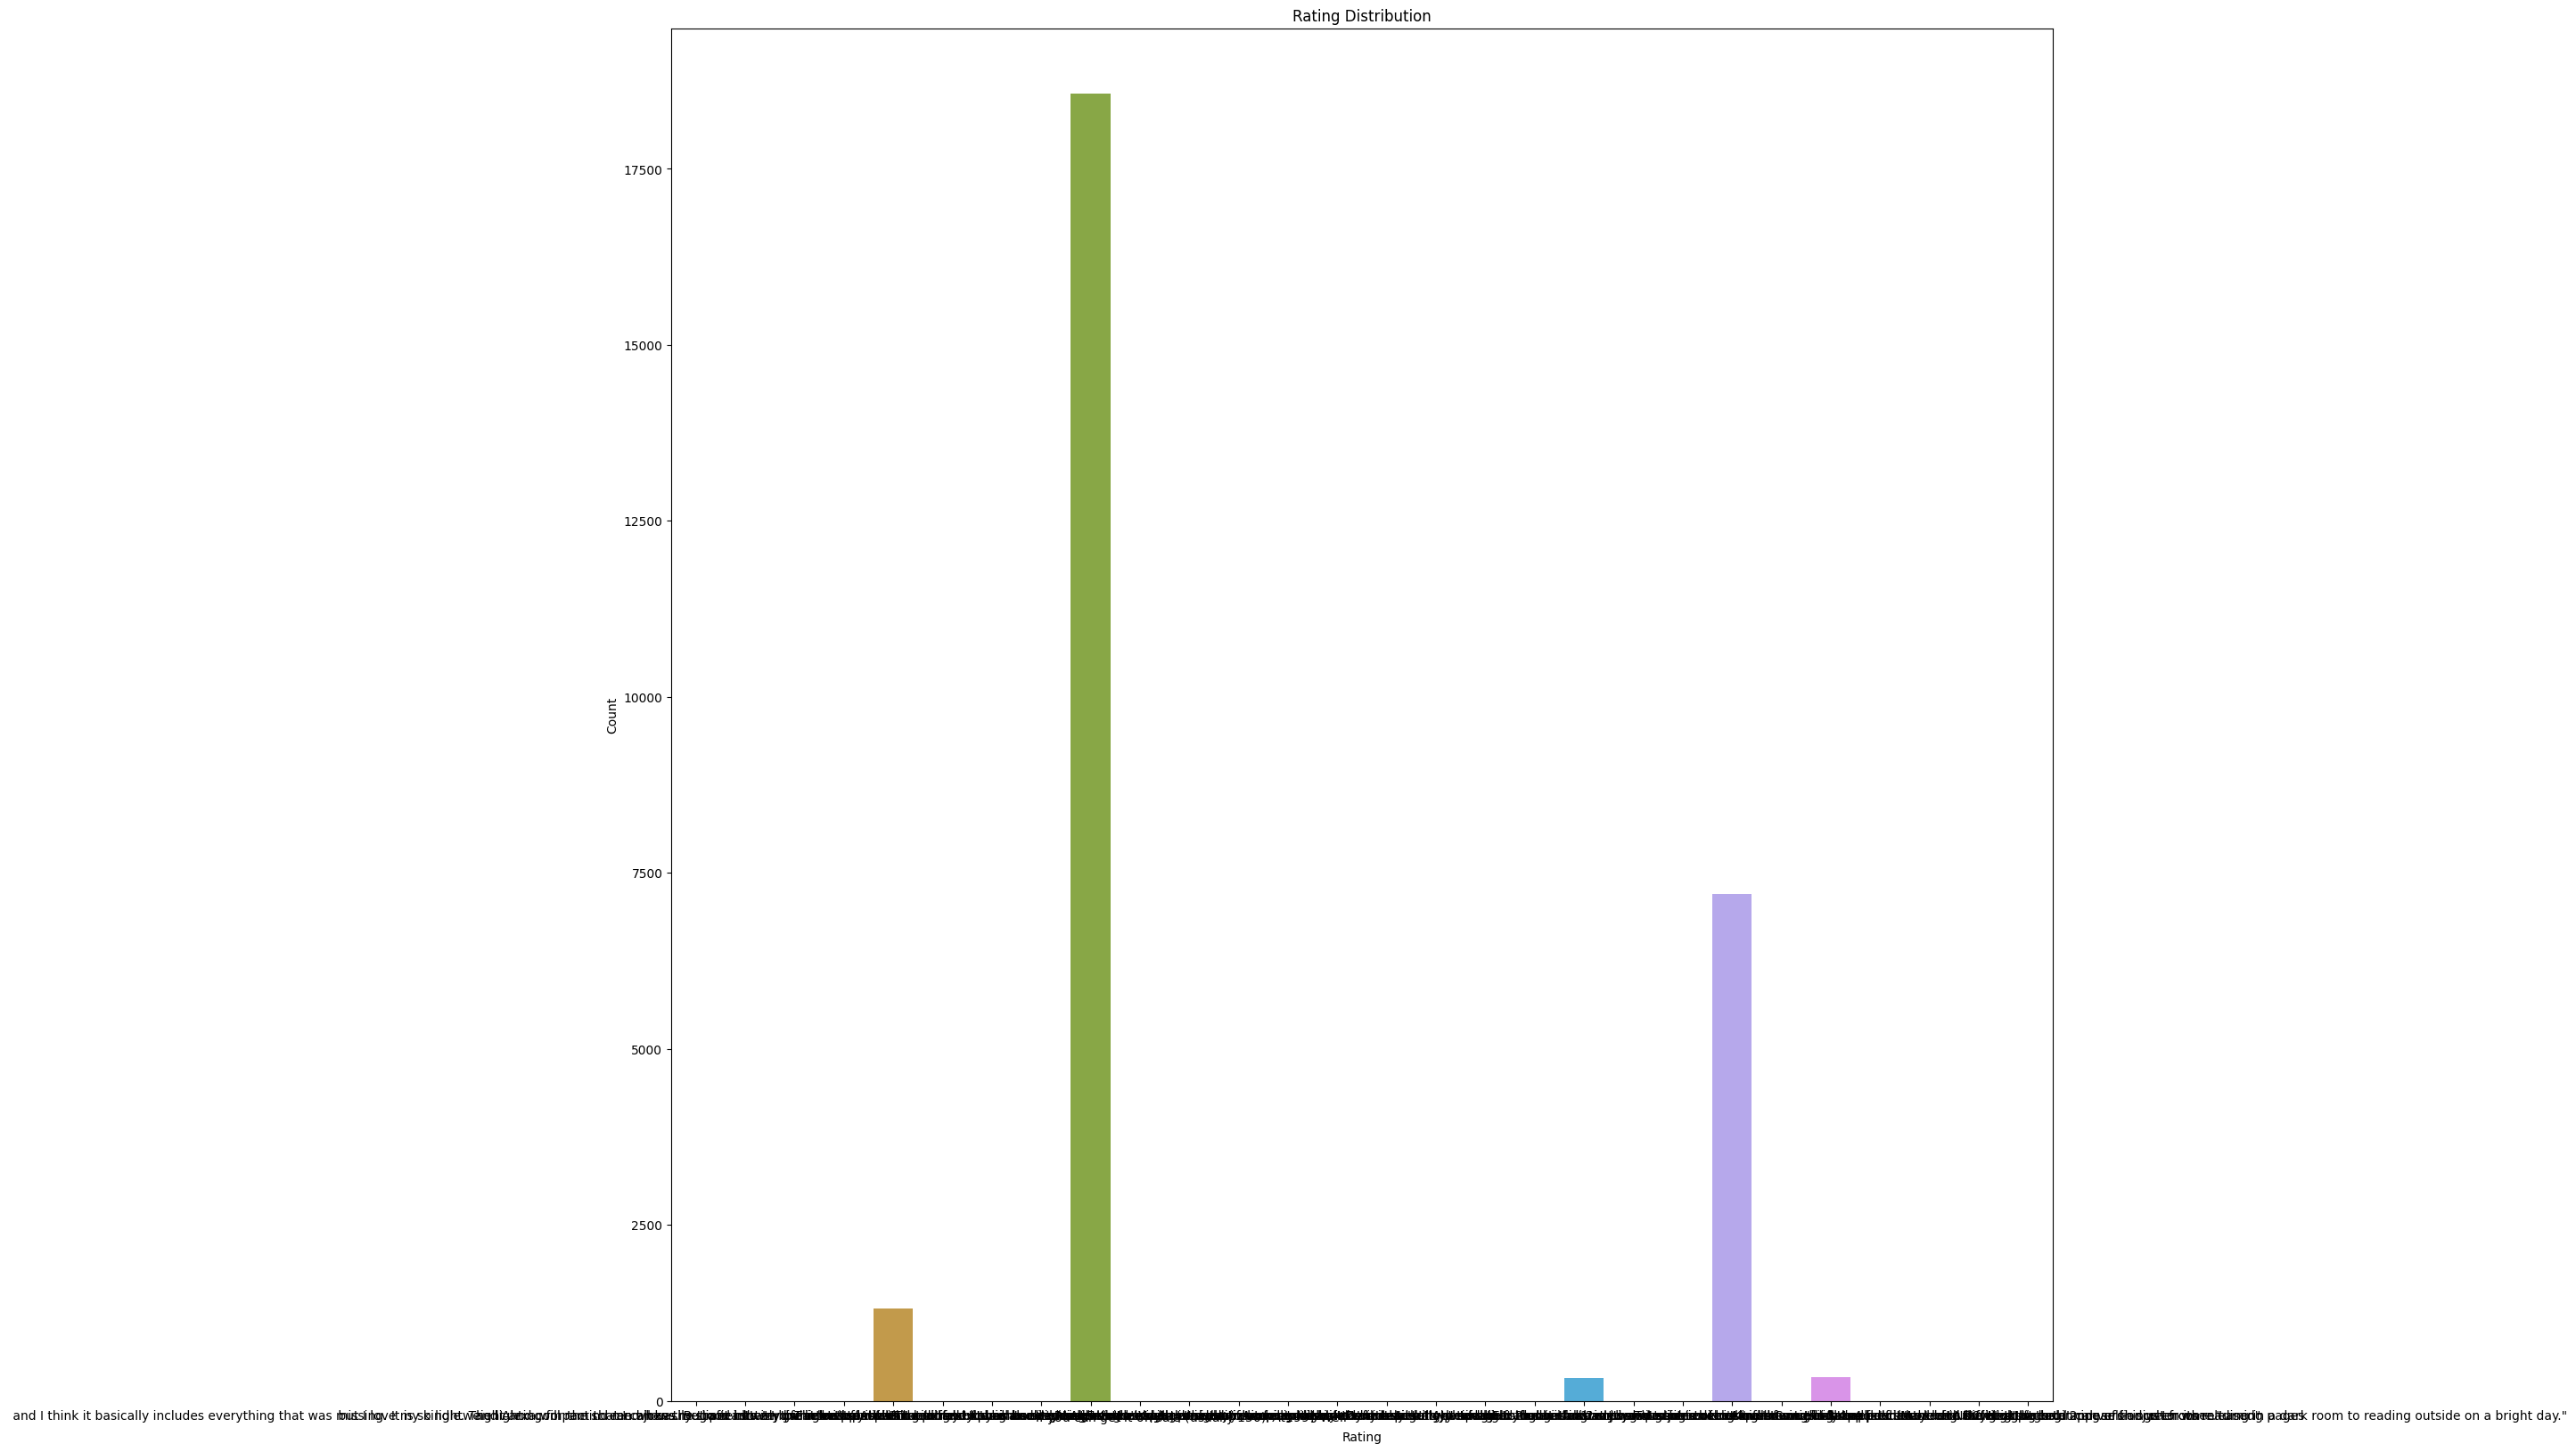

In [5]:
#problem
rating_counts = spark_data.groupBy("reviews_rating").count()
rating_counts_pd = rating_counts.toPandas()

# Bar plot of rating counts
plt.figure(figsize=(20, 20))
sns.barplot(x='reviews_rating', y='count', data=rating_counts_pd)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()


In [6]:
!pip install contractions


from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.7 MB/s eta 0:00:00


In [7]:
# Download necessary resources
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler

tokenizer = Tokenizer(inputCol='reviews_text', outputCol='tokenized_text')
spark_data = tokenizer.transform(spark_data)

stop_remove = StopWordsRemover(inputCol='tokenized_text', outputCol='token_stop')
spark_data = stop_remove.transform(spark_data)

In [9]:


from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a UDF for sentiment analysis
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores["compound"]

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

In [11]:
# Define the Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleaner(text):
    new_text = re.sub(r"'s\b", " is", text)
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r"http\S+", "", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = new_text.lower().strip()

    cleaned_text = ''
    for token in new_text.split():
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '

    return cleaned_text

In [12]:
# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Apply your cleaner function
        cleaned_text = cleaner(text)

        # Tokenization
        tokens = word_tokenize(cleaned_text)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Reconstruct preprocessed text
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        # If the input is not a string, return an empty string
        return ''

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define the UDF for preprocessing text
preprocess_text_udf = udf(preprocess_text, StringType())

# Apply the UDF to 'reviews_text' column and create a new column 'cleaned_reviews'
spark_data = spark_data.withColumn('cleaned_reviews', preprocess_text_udf(spark_data['reviews_text']))


In [15]:
spark_data.head()

Row(id='AVqkIhwDv8e3D1O-lebb', Category='Tablet', name=' Fire HD 8 Tablet, 16 GB ', reviews_rating='5', reviews_text='This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.', tokenized_text=['this', 'product', 'so', 'far', 'has', 'not', 'disappointed.', 'my', 'children', 'love', 'to', 'use', 'it', 'and', 'i', 'like', 'the', 'ability', 'to', 'monitor', 'control', 'what', 'content', 'they', 'see', 'with', 'ease.'], token_stop=['product', 'far', 'disappointed.', 'children', 'love', 'use', 'like', 'ability', 'monitor', 'control', 'content', 'see', 'ease.'], cleaned_reviews='product far ha disappointed child love use like ability monitor control content see ease')

In [16]:
!pip install wordcloud

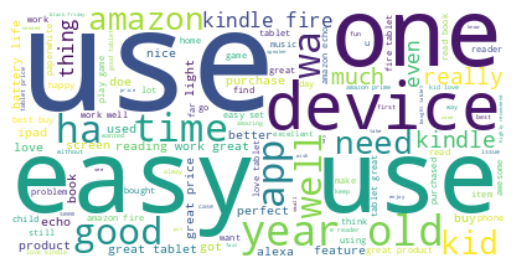

In [17]:
# Import the necessary libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Preprocess the text data
preprocessed_text = spark_data.select('cleaned_reviews').rdd.flatMap(lambda x: x).collect()
text = ' '.join(preprocessed_text)

# Generate the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
csv_path = "/content/drive/MyDrive/One&only5.csv"
spark_data.write.option("header", "true").csv

<bound method DataFrameWriter.csv of <pyspark.sql.readwriter.DataFrameWriter object at 0x7af31b6e9060>>